In [1]:
import os

In [2]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [3]:
os.chdir('/content/drive/MyDrive')

In [4]:
os.getcwd()

'/content/drive/MyDrive'

This is a multi-class image classifier that have 8 classes and only few images in the training set for each class.

The dataset used here is a derivation of the “Natural Images” dataset (https://www.kaggle.com/prasunroy/natural-images/version/1#_=_ ) . The number of images in the original dataset has been reduced randomly for building the “Mini Natural Images”. This dataset consists of three phases for train, test and validation.

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy
import seaborn as sn
import pandas as pd
# import torchnet.meter.confusionmeter as cm

In [2]:
# Data augmentation and normalization for training
# Just normalization for validation & test
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(224),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'test': transforms.Compose([
        transforms.Resize(224),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])
}

In [3]:
data_dir = '/home/tavakol/uni/ml4021/'

In [4]:
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                  for x in ['train', 'val']}

In [5]:
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=16,
                                             shuffle=True, num_workers=4)
              for x in ['train', 'val']}

In [7]:
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
class_names = image_datasets['train'].classes

In [8]:
dataset_sizes, class_names

({'train': 244, 'val': 153}, ['ants', 'bees'])

In [9]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [10]:
#lists for graph generation
epoch_counter_train = []
epoch_counter_val = []
train_loss = []
val_loss = []
train_acc = []
val_acc = []


In [11]:
#Train the model
def train_model(model, criterion, optimizer, scheduler, num_epochs):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch +1, num_epochs))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                scheduler.step()
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            #For graph generation
            if phase == "train":
                train_loss.append(running_loss/dataset_sizes[phase])
                train_acc.append(running_corrects.double() / dataset_sizes[phase])
                epoch_counter_train.append(epoch)
            if phase == "val":
                val_loss.append(running_loss/ dataset_sizes[phase])
                val_acc.append(running_corrects.double() / dataset_sizes[phase])
                epoch_counter_val.append(epoch)

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            #for printing
            if phase == "train":
                epoch_loss = running_loss / dataset_sizes[phase]
                epoch_acc = running_corrects.double() / dataset_sizes[phase]
            if phase == "val":
                epoch_loss = running_loss / dataset_sizes[phase]
                epoch_acc = running_corrects.double() / dataset_sizes[phase]


            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            # deep copy the best model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

Using a model pre-trained on ImageNet and replacing it's final linear layer

In [13]:
#For resnet18
model_ft = models.resnet18(pretrained=True)
num_ftrs = model_ft.fc.in_features
model_ft.fc = nn.Linear(num_ftrs, 8)


/home/tavakol/.local/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /home/tavakol/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100.0%


In [14]:
# #for VGG16_BN
# model_ft = models.vgg16_bn(pretrained=True)
# model_ft.classifier[6].out_features = 8

In [15]:
model_ft = model_ft.to(device)

In [16]:
criterion = nn.CrossEntropyLoss()

# Using Adam as the parameter optimizer
optimizer_ft = optim.Adam(model_ft.parameters(), lr = 0.001, betas=(0.9, 0.999))

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)



In [17]:
model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler,
                       num_epochs=25)

Epoch 1/25
----------


/home/tavakol/.local/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:136: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn("Detected call of `lr_scheduler.step()` before `optimizer.step()`. "


train Loss: 1.2134 Acc: 0.6516
val Loss: 17.3337 Acc: 0.6013

Epoch 2/25
----------
train Loss: 0.8335 Acc: 0.5492
val Loss: 3.3452 Acc: 0.6928

Epoch 3/25
----------
train Loss: 0.6457 Acc: 0.6189
val Loss: 0.8332 Acc: 0.6993

Epoch 4/25
----------
train Loss: 0.6116 Acc: 0.6680
val Loss: 0.7225 Acc: 0.7386

Epoch 5/25
----------
train Loss: 0.5695 Acc: 0.6967
val Loss: 0.7684 Acc: 0.7190

Epoch 6/25
----------
train Loss: 0.5508 Acc: 0.7049
val Loss: 0.5099 Acc: 0.7516

Epoch 7/25
----------
train Loss: 0.4782 Acc: 0.7746
val Loss: 0.5072 Acc: 0.7647

Epoch 8/25
----------
train Loss: 0.4568 Acc: 0.7623
val Loss: 0.5087 Acc: 0.7908

Epoch 9/25
----------
train Loss: 0.4888 Acc: 0.7418
val Loss: 0.4989 Acc: 0.7974

Epoch 10/25
----------
train Loss: 0.4673 Acc: 0.7910
val Loss: 0.4767 Acc: 0.7843

Epoch 11/25
----------
train Loss: 0.4558 Acc: 0.7623
val Loss: 0.4830 Acc: 0.7908

Epoch 12/25
----------
train Loss: 0.4445 Acc: 0.7869
val Loss: 0.4769 Acc: 0.7974

Epoch 13/25
----------

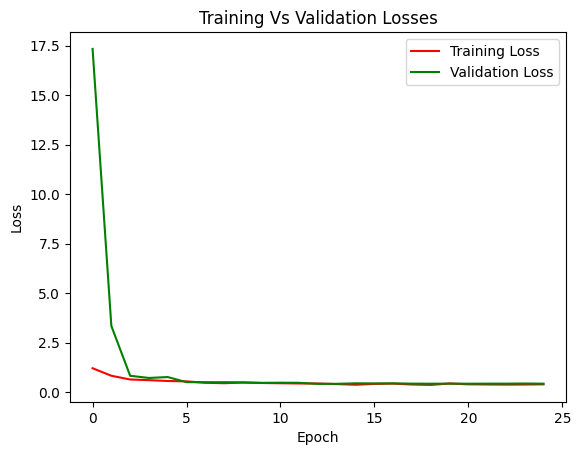

In [18]:
#Plot the train & validation losses
plt.figure(1)
plt.title("Training Vs Validation Losses")
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.plot(epoch_counter_train,train_loss,color = 'r', label="Training Loss")
plt.plot(epoch_counter_val,val_loss,color = 'g', label="Validation Loss")
plt.legend()
plt.show()

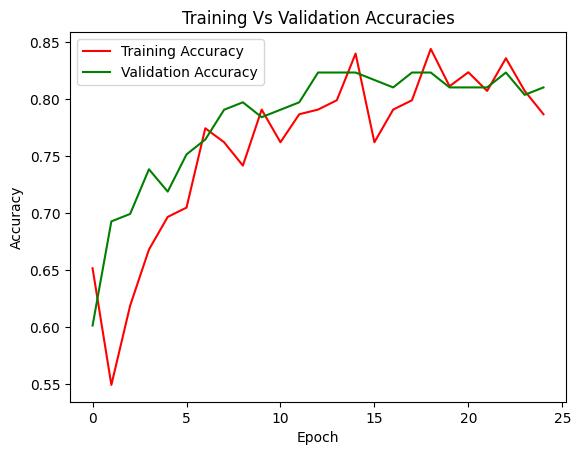

In [19]:
#Plot the accuracies in train & validation
plt.figure(2)
plt.title("Training Vs Validation Accuracies")
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.plot(epoch_counter_train, torch.tensor(train_acc).cpu().numpy(), color='r', label="Training Accuracy")
plt.plot(epoch_counter_val, torch.tensor(val_acc).cpu().numpy(), color='g', label="Validation Accuracy")
plt.legend()
plt.show()

In [21]:
#Test the accuracy with test data
correct = 0
total = 0
with torch.no_grad():
    for i, (inputs, labels) in enumerate(dataloaders['val']):
            inputs = inputs.to(device)
            labels = labels.to(device)
            outputs = model_ft(inputs)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

print('Accuracy of the network on the test images: %d %%' % (
    100 * correct / total))

Accuracy of the network on the test images: 82 %


In [22]:
#Class wise testing accuracy
class_correct = list(0. for i in range(8))
class_total = list(0. for i in range(8))
with torch.no_grad():
    for i, (inputs, labels) in enumerate(dataloaders['val']):
            inputs = inputs.to(device)
            labels = labels.to(device)
            outputs = model_ft(inputs)
            _, predicted = torch.max(outputs, 1)
            point = (predicted == labels).squeeze()
            for j in range(len(labels)):
                label = labels[j]
                class_correct[label] += point[j].item()
                class_total[label] += 1

In [25]:
for i in range(2):
    print('Accuracy of %5s : %2d %%' % (
        class_names[i], 100 * class_correct[i] / class_total[i]))


Accuracy of  ants : 84 %
Accuracy of  bees : 80 %


In [29]:
#Get the confusion matrix for testing data
confusion_matrix = cm.ConfusionMeter(8)
with torch.no_grad():
    for i, (inputs, labels) in enumerate(dataloaders['test']):
        inputs = inputs.to(device)
        labels = labels.to(device)
        outputs = model_ft(inputs)
        _, predicted = torch.max(outputs, 1)
        confusion_matrix.add(predicted, labels)
    print(confusion_matrix.conf)

[[104   1   0   0   0   0   2   0]
 [  1 281   0   2   1   1   2   0]
 [  1   0 158  56   0   0   0   0]
 [  1   1  98 127   3   1   0   1]
 [  0   0   0   8 211   3   1   0]
 [  0   0   0   0   0 349   1   0]
 [  0   0   0   0   1   0 207   0]
 [  0   0   4   5   0   0   1 276]]


<Axes: >

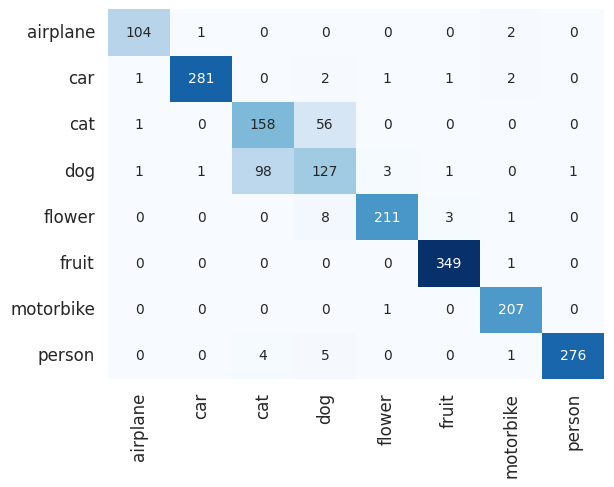

In [30]:
#Confusion matrix as a heatmap
con_m = confusion_matrix.conf
df_con_m = pd.DataFrame(con_m, index= [i for i in class_names], columns = [i for i in class_names])
sn.set(font_scale= 1.1)
sn.heatmap(df_con_m, annot=True,fmt='g' ,  annot_kws={"size" : 10}, cbar = False, cmap="Blues")

In [26]:
from matplotlib.pyplot import imshow


def visualize_model_predictions(model,img_path):
    was_training = model.training
    model.eval()

    img = Image.open(img_path)
    img = data_transforms['val'](img)
    img = img.unsqueeze(0)
    img = img.to(device)

    with torch.no_grad():
        outputs = model(img)
        _, preds = torch.max(outputs, 1)

        ax = plt.subplot(2,2,1)
        ax.axis('off')
        ax.set_title(f'Predicted: {class_names[preds[0]]}')
        imshow(img.cpu().data[0])

        model.train(mode=was_training)

https://github.com/haritha91/Multiclass-Image-Classifier-pytorch-Transfer-Learning